In [1]:
import numpy as np
import random

from sklearn.mixture import GaussianMixture
from scipy.stats import multivariate_normal as mvn
import itertools
from scipy import linalg
from scipy import stats as st

# for multivariate data distance calculation 
from scipy.spatial import distance
from scipy.stats import chi2

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
list_ra = []
list_rb = []
list_rc = []

for i in range(100):
    
    x = random.uniform(0, 1)
    y = random.uniform(0, 1)
    
    list_ra.append([x,y])
    list_rb.append([x+5, y+5])
    list_rc.append([x+10, y+10])
    
list_ra = np.array(list_ra)
list_rb = np.array(list_rb)
list_rc = np.array(list_rc)

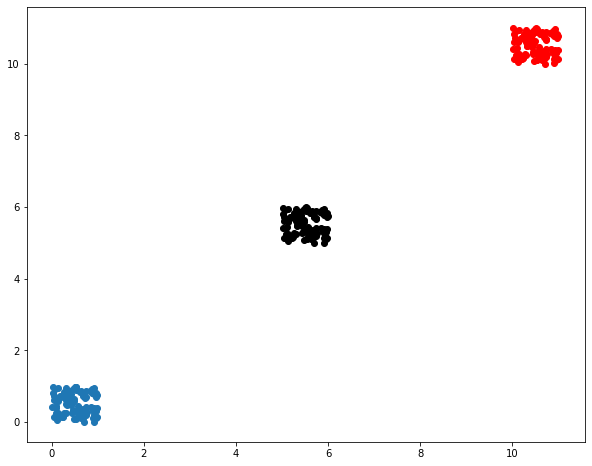

In [3]:
plt.figure(figsize = (10,8))
plt.scatter(x=list_ra[:,0],y=list_ra[:,1], cmap='viridis')
plt.scatter(x=list_rb[:,0],y=list_rb[:,1],c='black');
plt.scatter(x=list_rc[:,0],y=list_rc[:,1],c='red');

In [4]:
full_list = np.concatenate((list_ra,list_rb, list_rc))

In [5]:
full_list.shape

(300, 2)

In [6]:
gmm = GaussianMixture(n_components=3, covariance_type='full', max_iter=1000).fit(full_list)

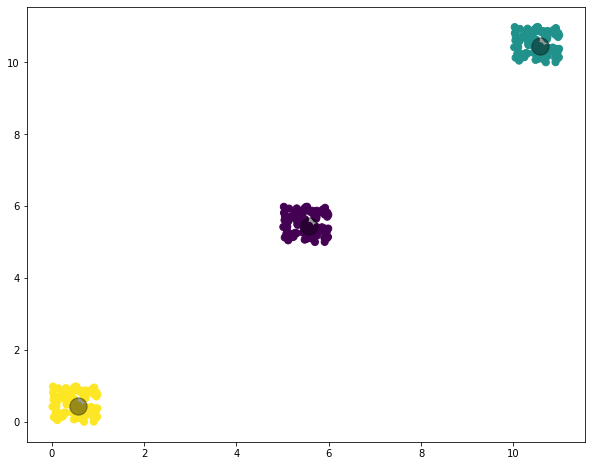

In [7]:
prediction_gmm = gmm.predict(full_list)
probs = gmm.predict_proba(full_list)

centers = np.zeros((3,2))
for i in range(3):
    density = mvn(cov=gmm.covariances_[i], mean=gmm.means_[i]).logpdf(full_list)
    centers[i, :] = full_list[np.argmax(density)]

plt.figure(figsize = (10,8))
plt.scatter(full_list[:, 0], full_list[:, 1],c=prediction_gmm ,s=50, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1],c='black', s=300, alpha=0.4);

In [8]:
centers

array([[ 5.57588891,  5.4518278 ],
       [10.57588891, 10.4518278 ],
       [ 0.57588891,  0.4518278 ]])

In [9]:
gmm.covariances_

array([[[ 0.08599283, -0.01232166],
        [-0.01232166,  0.08205254]],

       [[ 0.08599283, -0.01232166],
        [-0.01232166,  0.08205254]],

       [[ 0.08599283, -0.01232166],
        [-0.01232166,  0.08205254]]])

In [10]:
gmm.means_

array([[ 5.51490639,  5.50286993],
       [10.51490639, 10.50286993],
       [ 0.51490639,  0.50286993]])

In [11]:
sample_data = np.asarray([-1,-1]).reshape(1, -1)

In [12]:
thresh = 0.05
print("Threshold: {:.3f}".format(thresh))
print("-----------------\n\n")

for i in range(len(gmm.means_)):
    print("Component: {}".format(i))
    
    m_dis = distance.mahalanobis(sample_data, gmm.means_[i,:], np.linalg.inv(gmm.covariances_[i,:]))
    print("dis: {:.3f}".format(m_dis))

    # chi square for k-1 = 2-1 = 1
    sig = 1 - chi2.cdf(m_dis,1)
    print("p-val: {:.3f}".format(sig))

    if sig < thresh:
        print("Result: Outlier!")
    else:
        print("Result: O.K!")
    
    print("-----")

Threshold: 0.050
-----------------


Component: 0
dis: 34.385
p-val: 0.000
Result: Outlier!
-----
Component: 1
dis: 60.800
p-val: 0.000
Result: Outlier!
-----
Component: 2
dis: 7.971
p-val: 0.005
Result: Outlier!
-----


In [13]:
scores = []

for i in range(3):
    scores.append(mvn.pdf(sample_data,gmm.means_[i,:], gmm.covariances_[i,:] ))
    
print("Component 0: {:.3f}\nComponent 1: {:.3f}\nComponent 2: {:.3f}".format(scores[0],scores[1],scores[2]))

Component 0: 0.000
Component 1: 0.000
Component 2: 0.000


In [14]:
## BIC for selection of number of parameter in GMM

In [15]:
lowest_bic = np.infty

bic = []
n_components_range = range(3, 10)
cv_types = ['spherical', 'tied', 'diag', 'full']

for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = GaussianMixture(n_components=n_components, covariance_type=cv_type, max_iter=100000)
        
        gmm.fit(full_list)
        bic.append(gmm.bic(full_list))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm

bic = np.array(bic)
clf = best_gmm

In [16]:
clf.covariance_type

'tied'

In [17]:
clf.get_params

<bound method BaseEstimator.get_params of GaussianMixture(covariance_type='tied', init_params='kmeans', max_iter=100000,
                means_init=None, n_components=7, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)>

In [18]:
lowest_bic

914.322775047993

In [19]:
## New synthetic data
from sklearn.datasets import make_blobs
from pandas import DataFrame

from sklearn.utils.extmath import softmax

In [20]:
X, y = make_blobs(n_samples=100, centers=3, n_features=2, cluster_std=3000, center_box = (-50000,50000),random_state=0)

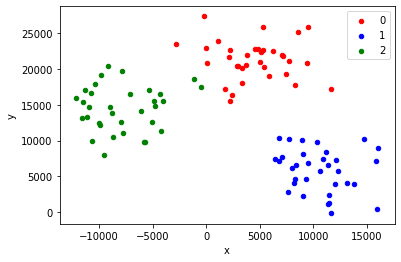

In [21]:
# scatter plot, dots colored by class value
df = DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
colors = {0:'red', 1:'blue', 2:'green'}
fig, ax = plt.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
plt.show()

In [22]:
gmm = GaussianMixture(n_components=3, covariance_type='full', max_iter=1000).fit(X)

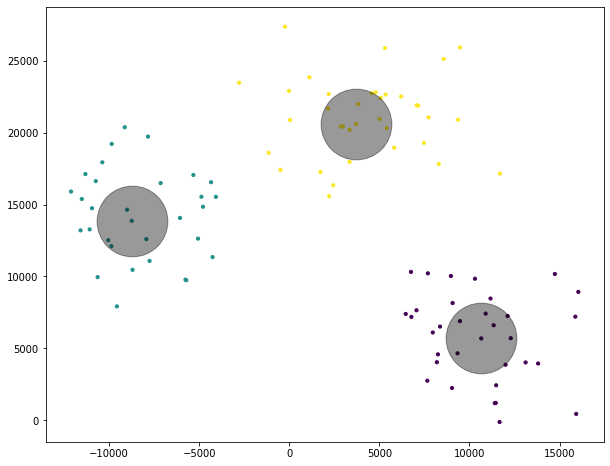

In [23]:
prediction_gmm = gmm.predict(X)
probs = gmm.predict_proba(X)

centers = np.zeros((3,2))
for i in range(3):
    density = mvn(cov=gmm.covariances_[i], mean=gmm.means_[i]).logpdf(X)
    centers[i, :] = X[np.argmax(density)]

plt.figure(figsize = (10,8))
plt.scatter(X[:, 0], X[:, 1],c=prediction_gmm ,s=10, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=5000, alpha=0.4);

In [24]:
sample_data = np.array([0,15000])

In [25]:
thresh = 0.05
print("Threshold: {:.3f}".format(thresh))
print("-----------------\n\n")

for i in range(len(gmm.means_)):
    print("Component: {}".format(i))
    
    m_dis = distance.mahalanobis(sample_data, gmm.means_[i,:], np.linalg.inv(gmm.covariances_[i,:]))
    print("dis: {:.3f}".format(m_dis))

    # chi square for k-1 = 2-1 = 1
    sig = 1 - chi2.cdf(m_dis,1)
    print("p-val: {:.3f}".format(sig))

    if sig < thresh:
        print("Result: Outlier!")
    else:
        print("Result: O.K!")
    
    print("-----")

Threshold: 0.050
-----------------


Component: 0
dis: 4.555
p-val: 0.033
Result: Outlier!
-----
Component: 1
dis: 3.278
p-val: 0.070
Result: O.K!
-----
Component: 2
dis: 2.521
p-val: 0.112
Result: O.K!
-----


In [26]:
scores = []

for i in range(3):
    scores.append(mvn.pdf(sample_data,gmm.means_[i,:], gmm.covariances_[i,:] ))
    
print("Component 0: {:.20f}\nComponent 1: {:.20f}\nComponent 2: {:.20f}".format(scores[0],scores[1],scores[2]))

Component 0: 0.00000000000063152329
Component 1: 0.00000000009436931261
Component 2: 0.00000000072945543964
